[Videos Youtube](https://www.youtube.com/watch?v=Uokg7xttUhU&list=PL3qBTZ_EXTNfwupimSbTMaZswDQh9LjIS)

# Taxi Fare Prediction

* Adaptado de https://towardsdatascience.com/another-machine-learning-walk-through-and-a-challenge-8fae1e187a64
* [Execute o notebook no kaggle](https://www.kaggle.com/fycher/encontro-geam-ny-taxi-fare)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

palette = sns.color_palette('Paired', 10)
plt.style.use('seaborn-darkgrid')

RSEED = 42

In [2]:
data = pd.read_csv('../input/train.csv', nrows = 1_000_000, 
                   parse_dates = ['pickup_datetime']).drop(columns = 'key')

data.dropna(inplace=True)
data.drop_duplicates(inplace=True)
data.head()

fare_amount           pickup_datetime  pickup_longitude  pickup_latitude  \
0          4.5 2009-06-15 17:26:21+00:00        -73.844311        40.721319   
1         16.9 2010-01-05 16:52:16+00:00        -74.016048        40.711303   
2          5.7 2011-08-18 00:35:00+00:00        -73.982738        40.761270   
3          7.7 2012-04-21 04:30:42+00:00        -73.987130        40.733143   
4          5.3 2010-03-09 07:51:00+00:00        -73.968095        40.768008   

   dropoff_longitude  dropoff_latitude  passenger_count  
0         -73.841610         40.712278                1  
1         -73.979268         40.782004                1  
2         -73.991242         40.750562                2  
3         -73.991567         40.758092                1  
4         -73.956655         40.783762                1

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 999990 entries, 0 to 999999
Data columns (total 7 columns):
fare_amount          999990 non-null float64
pickup_datetime      999990 non-null datetime64[ns, UTC]
pickup_longitude     999990 non-null float64
pickup_latitude      999990 non-null float64
dropoff_longitude    999990 non-null float64
dropoff_latitude     999990 non-null float64
passenger_count      999990 non-null int64
dtypes: datetime64[ns, UTC](1), float64(5), int64(1)
memory usage: 61.0 MB


# Identificando Outliers

In [4]:
data.describe()

fare_amount  pickup_longitude  pickup_latitude  dropoff_longitude  \
count  999990.000000     999990.000000    999990.000000      999990.000000   
mean       11.347953        -72.526699        39.929040         -72.527860   
std         9.821790         12.057778         7.626087          11.324494   
min       -44.900000      -3377.680935     -3116.285383       -3383.296608   
25%         6.000000        -73.992060        40.734965         -73.991385   
50%         8.500000        -73.981792        40.752695         -73.980135   
75%        12.500000        -73.967094        40.767154         -73.963654   
max       500.000000       2522.271325      2621.628430          45.581619   

       dropoff_latitude  passenger_count  
count     999990.000000    999990.000000  
mean          39.919954         1.684941  
std            8.201418         1.323907  
min        -3114.338567         0.000000  
25%           40.734046         1.000000  
50%           40.753166         1.000000  
75%           40.768129         2.000000  
max         1651.553433       208.000000

### Exploração e Limpeza dos dados

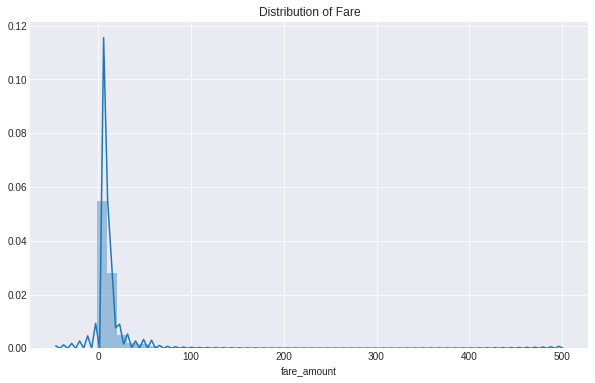

In [5]:
plt.figure(figsize = (10, 6))
sns.distplot(data['fare_amount'])
plt.title('Distribution of Fare');

In [6]:
print("Passagens com valor negativo: {}".format(len(data[data['fare_amount'] < 0])))
print("Passagens com valor 0: {}".format(len(data[data['fare_amount'] == 0])))
print("Passagens com valor maior : {}".format(len(data[data['fare_amount'] > 100])))

Passagens com valor negativo: 38
Passagens com valor 0: 29
Passagens com valor maior : 396


### Removendo Outliers

Baseado [nesta matéria](http://nymag.com/nymetro/urban/features/taxi/n_20286/), removeremos as passagens com valor menor que $2.5.

* Tambem limitaremos o valor máximo das passagens a $100.0.

In [7]:
data = data[data['fare_amount'].between(left = 2.5, right = 100)]

Discretizamos as passagens para visualizar suas distribuições

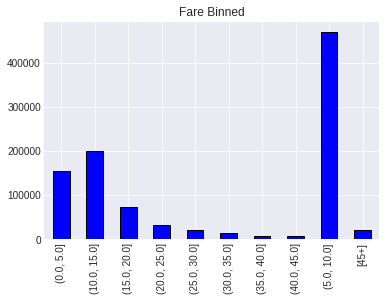

In [8]:
# Discretiza os valores das passagens em faixas
data['fare-bin'] = pd.cut(data['fare_amount'], bins = list(range(0, 50, 5))).astype(str)
data.loc[data['fare-bin'] == 'nan', 'fare-bin'] = '[45+]'

# Visualizando as faixas de valores
data.loc[data['fare-bin'] == '(5, 10]', 'fare-bin'] = '(05, 10]'
data['fare-bin'].value_counts().sort_index().plot.bar(color = 'b', edgecolor = 'k')
plt.title('Fare Binned');

### Outros Outliers

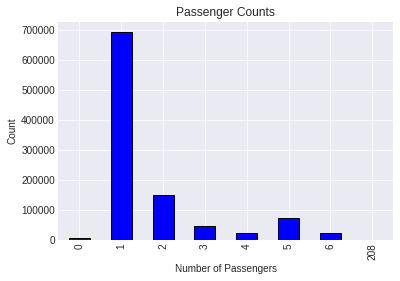

In [9]:
data['passenger_count'].value_counts().sort_index().plot.bar(color = 'b', edgecolor = 'k')
plt.title('Passenger Counts')
plt.xlabel('Number of Passengers')
plt.ylabel('Count');

In [10]:
data = data.loc[data['passenger_count'] <= 6]

Para `latitude` e `longitude`, removeremos os valores abaixo de 2.5% e acima de 97,5% percentil.

In [11]:
print('Observasões iniciais: {}'.format(data.shape[0]))

Observasões iniciais: 999516


In [12]:
for col in ['pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude']:
    print(f'{col.capitalize():17}: 2.5% = {round(np.percentile(data[col], 2.5), 2):5} \t 97.5% = {round(np.percentile(data[col], 97.5), 2)}')

Pickup_latitude  : 2.5% = 40.64 	 97.5% = 40.8
Pickup_longitude : 2.5% = -74.01 	 97.5% = -73.78
Dropoff_latitude : 2.5% = 40.64 	 97.5% = 40.81
Dropoff_longitude: 2.5% = -74.01 	 97.5% = -73.78


In [13]:
# Remover latitude e longtiude outliers
data = data.loc[data['pickup_latitude'].between(40, 41)]
data = data.loc[data['pickup_longitude'].between(-74, -73)]
data = data.loc[data['dropoff_latitude'].between(40, 41)]
data = data.loc[data['dropoff_longitude'].between(-74, -73)]

print('Novas observações: {}'.format(data.shape[0]))

Novas observações: 753057


Agora podemos exibir `latitude` e `longitude` para ver a distributioção. Usaremos apenas 1000 observações.

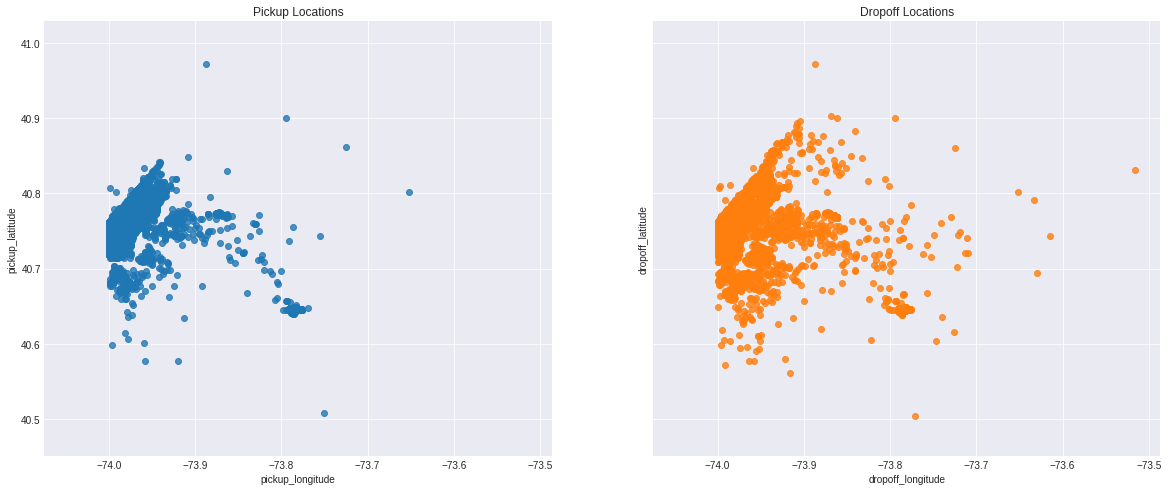

In [14]:
fig, axes = plt.subplots(1, 2, figsize = (20, 8), sharex=True, sharey=True)
axes = axes.flatten()

# Plot Longitude (x) e Latitude (y)
sns.regplot('pickup_longitude', 'pickup_latitude', fit_reg = False, 
            data = data.sample(10000, random_state = RSEED), ax = axes[0]);
sns.regplot('dropoff_longitude', 'dropoff_latitude', fit_reg = False, 
            data = data.sample(10000, random_state = RSEED), ax = axes[1]);
axes[0].set_title('Pickup Locations')
axes[1].set_title('Dropoff Locations');

# Visualizando o dataset

Para uma representação mais contextualizada, podemos traçar a coleta e a entrega em cima de um mapa de Nova York

In [15]:
BB_zoom = (-74.1, -73.7, 40.6, 40.85)
nyc_map_zoom = plt.imread("https://github.com/WillKoehrsen/Machine-Learning-Projects/blob/master/images/nyc_-74.1_-73.7_40.6_40.85.PNG?raw=true")

Essa função é para plotar os dados no mapa de Nova York

In [16]:
def plot_on_map(df, BB, nyc_map, s=10, alpha=0.2, color = False):
    fig, axs = plt.subplots(2, 1, figsize=(18, 22))
    axs[0].scatter(df.pickup_longitude, df.pickup_latitude, zorder=1, alpha=alpha, c='r', s=2)
    axs[0].set_xlim((BB[0], BB[1]))
    axs[0].set_ylim((BB[2], BB[3]))
    axs[0].set_title('Localizações de embarque')
    axs[0].axis('off')
    axs[0].imshow(nyc_map, zorder=0, extent=BB)

    axs[1].scatter(df.dropoff_longitude, df.dropoff_latitude, zorder=1, alpha=alpha, c='b', s=2)
    axs[1].set_xlim((BB[0], BB[1]))
    axs[1].set_ylim((BB[2], BB[3]))
    axs[1].set_title('Locais de desembarque')
    axs[1].axis('off')
    axs[1].imshow(nyc_map, zorder=0, extent=BB)

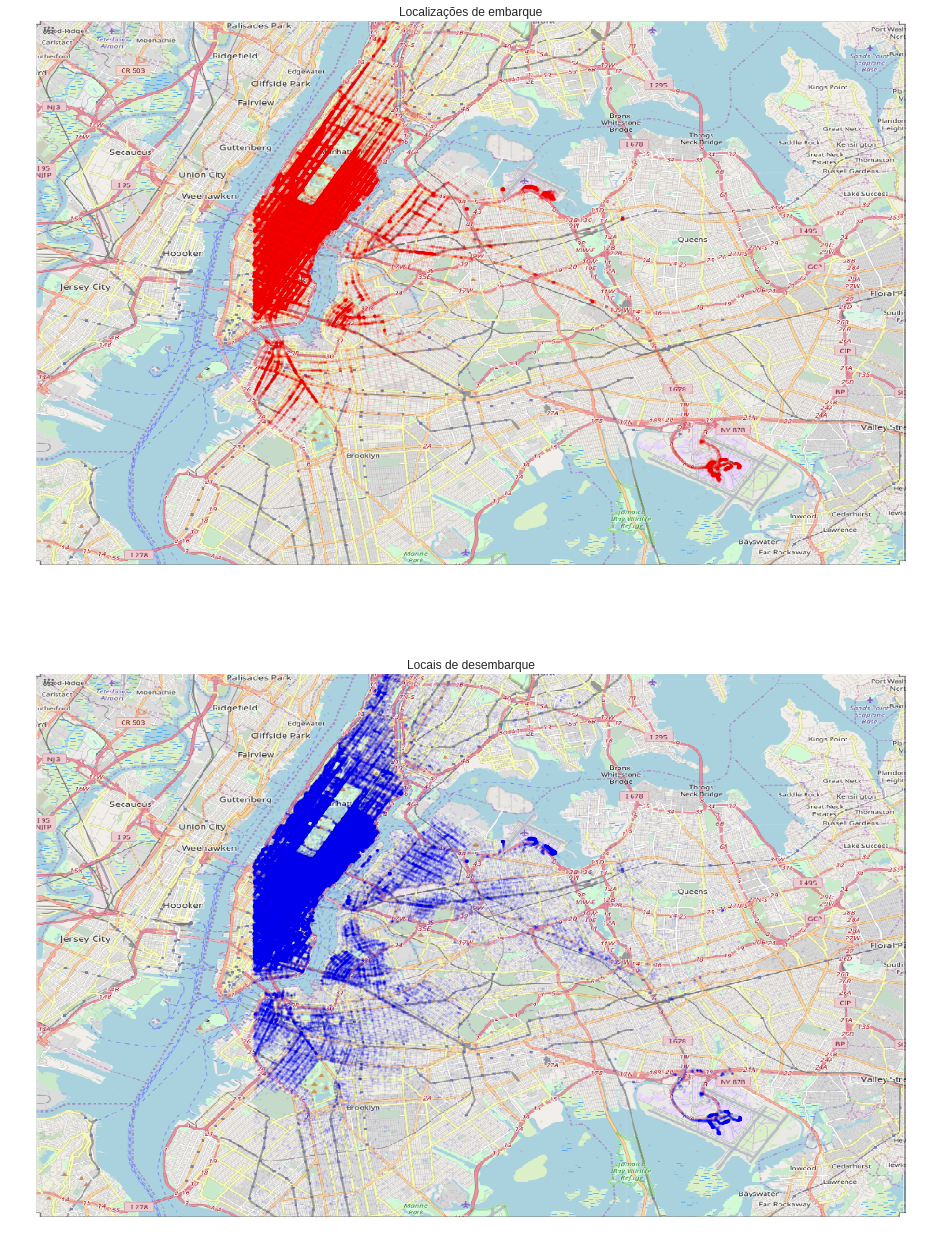

In [17]:
plot_on_map(data.sample(500_000, random_state = RSEED), 
            BB_zoom, nyc_map_zoom, s=0.05, alpha=0.05)

A maioria dos passeios está concentrada em Manhattan e aparentemente há mais passeios terminando fora de Manhattan do que dentro.

Para verificar se há uma diferença nos locais com base na tarifa, vamos mapear cada compartimento de tarifa para uma cor diferente e, em seguida, plotar o gráfico.

In [18]:
color_mapping = {fare_bin: palette[i] for i, fare_bin in enumerate(data['fare-bin'].unique())}
color_mapping

{'(0.0, 5.0]': (0.6509803921568628, 0.807843137254902, 0.8901960784313725),
 '(5.0, 10.0]': (0.12156862745098039, 0.47058823529411764, 0.7058823529411765),
 '(15.0, 20.0]': (0.6980392156862745, 0.8745098039215686, 0.5411764705882353),
 '(10.0, 15.0]': (0.2, 0.6274509803921569, 0.17254901960784313),
 '(30.0, 35.0]': (0.984313725490196, 0.6039215686274509, 0.6),
 '[45+]': (0.8901960784313725, 0.10196078431372549, 0.10980392156862745),
 '(25.0, 30.0]': (0.9921568627450981, 0.7490196078431373, 0.43529411764705883),
 '(20.0, 25.0]': (1.0, 0.4980392156862745, 0.0),
 '(40.0, 45.0]': (0.792156862745098, 0.6980392156862745, 0.8392156862745098),
 '(35.0, 40.0]': (0.41568627450980394,
  0.23921568627450981,
  0.6039215686274509)}

A função de mapa substituirá os valores em uma coluna pelos valores correspondentes no dicionário.

In [19]:
data['color'] = data['fare-bin'].map(color_mapping)
plot_data = data.sample(500_000, random_state = RSEED)

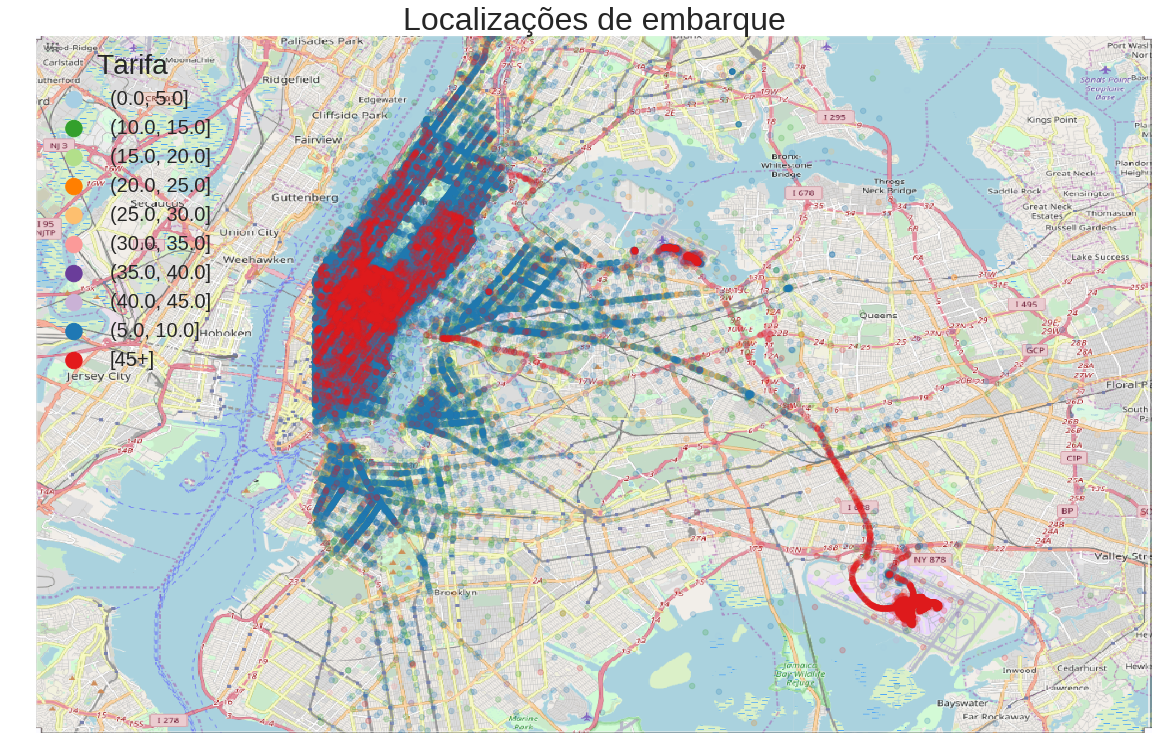

In [20]:
BB = BB_zoom

fig, axs = plt.subplots(1, 1, figsize=(20, 18))


for b, df in plot_data.groupby('fare-bin'):
    axs.scatter(df.pickup_longitude, df.pickup_latitude, zorder=1, alpha=0.2, c=df.color, s=30, label = f'{b}')
    axs.set_xlim((BB[0], BB[1]))
    axs.set_ylim((BB[2], BB[3]))
    axs.set_title('Localizações de embarque', size = 32)
    axs.axis('off')
    
# Legenda
leg = axs.legend(fontsize = 20, markerscale = 3)

for lh in leg.legendHandles: 
    lh.set_alpha(1)

leg.set_title('Tarifa', prop = {'size': 28})

axs.imshow(nyc_map_zoom, zorder=0, extent=BB_zoom);

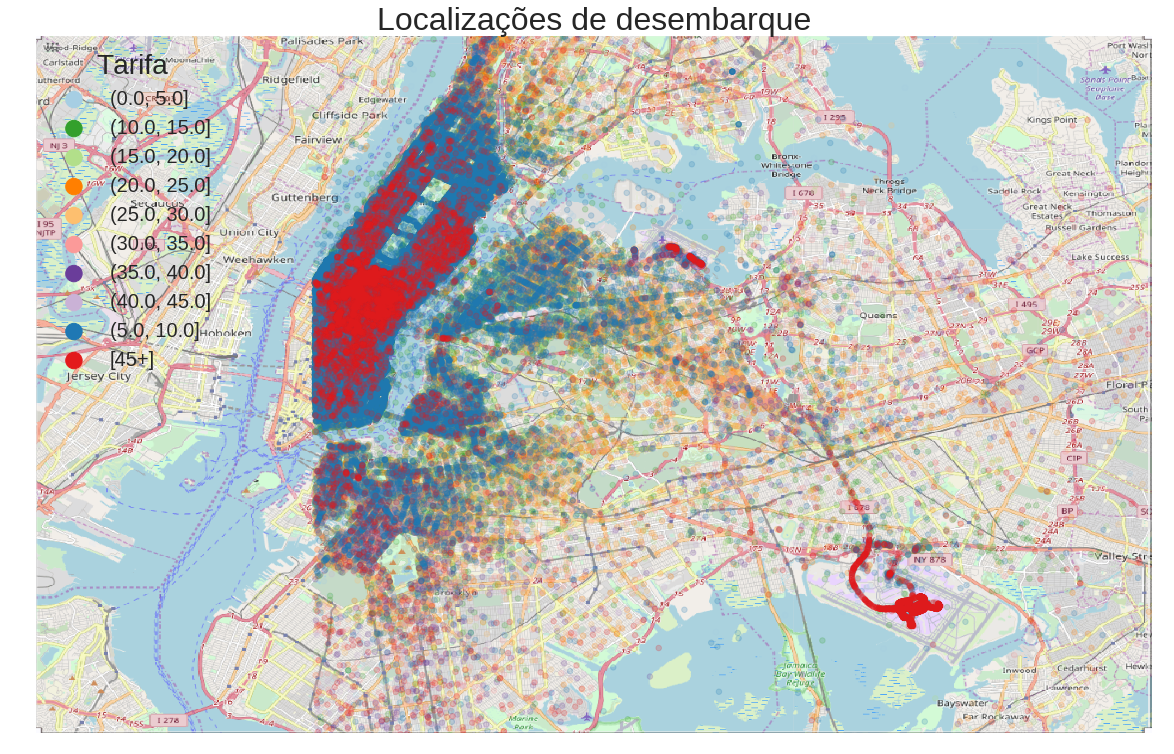

In [21]:
fig, axs = plt.subplots(1, 1, figsize=(20, 18))


for b, df in plot_data.groupby('fare-bin'):
    axs.scatter(df.dropoff_longitude, df.dropoff_latitude, zorder=1, 
                alpha=0.2, c=df.color, s=30, label = f'{b}')
    axs.set_xlim((BB[0], BB[1]))
    axs.set_ylim((BB[2], BB[3]))
    axs.set_title('Localizações de desembarque', size = 32)
    axs.axis('off')
    
# Legenda
leg = axs.legend(fontsize = 20, markerscale = 3)

for lh in leg.legendHandles: 
    lh.set_alpha(1)

leg.set_title('Tarifa', prop = {'size': 28})

axs.imshow(nyc_map_zoom, zorder=0, extent=BB_zoom);

Além de interessantes, os gráficos podem nos ajudar a identificar anomalias, relacionamentos ou idéias para novos recursos. 

Os passeios mais caros tendem a se agrupar em torno do aeroporto. Se soubéssemos com certeza que havia passeio com destino ao aeroporto, saberíamos a tarifa!

# Engenharia de Features

### Distância absoluta

In [22]:
data['abs_lat_diff'] = (data['dropoff_latitude'] - data['pickup_latitude']).abs()
data['abs_lon_diff'] = (data['dropoff_longitude'] - data['pickup_longitude']).abs()

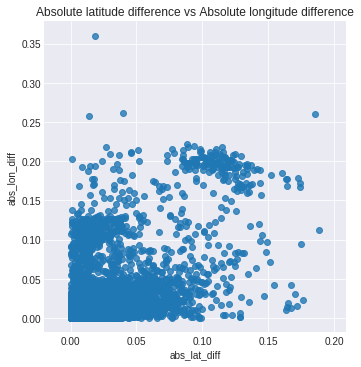

In [23]:
sns.lmplot('abs_lat_diff', 'abs_lon_diff', fit_reg = False,
           data = data.sample(10000, random_state=RSEED));
plt.title('Absolute latitude difference vs Absolute longitude difference');

Verificamos se existe alguma distância com valor 0.

In [24]:
data.shape, ((data['abs_lat_diff'] == 0) & (data['abs_lon_diff'] == 0)).sum()

((753057, 11), 8931)

Vamos remover essas observações

In [25]:
no_diff = (data['abs_lat_diff'] == 0) & (data['abs_lon_diff'] == 0)
data = data.loc[~no_diff]
data.shape

(744126, 11)

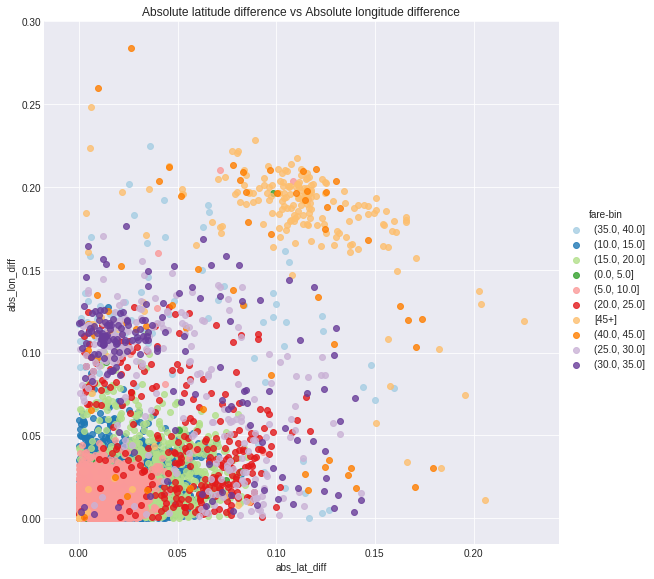

In [26]:
sns.lmplot('abs_lat_diff', 'abs_lon_diff', hue = 'fare-bin', height = 8, palette=palette,
           fit_reg = False, data = data.sample(10000, random_state=RSEED))
plt.title('Absolute latitude difference vs Absolute longitude difference');

> ### Distâncias de Manhattan e Euclidiana

[Distância de Minkowski](https://en.wikipedia.org/wiki/Minkowski_distance) entre dois pontos:

$${\displaystyle D\left(X,Y\right)=\left(\sum _{i=1}^{n}|x_{i}-y_{i}|^{p}\right)^{1/p}}$$

* se p = 1, temos a distancia de Manhattan, e se p = 2 temos a distancia Euclidiana.

In [27]:
def minkowski_distance(x1, x2, y1, y2, p):
    return ((abs(x2 - x1) ** p) + (abs(y2 - y1)) ** p) ** (1 / p)

In [28]:
print('Minkowski: {} \nEuclidiana: {}'.format(minkowski_distance(0, 3, 0, 4, 1), minkowski_distance(0, 3, 0, 4, 2)))

Minkowski: 7.0 
Euclidiana: 5.0


Aplicaremos estas funções para `latitude` e `longitude`. Lembrando que estas não são as distancias reais, pois estas funções são aplicadas considerando o plano cartesiano.

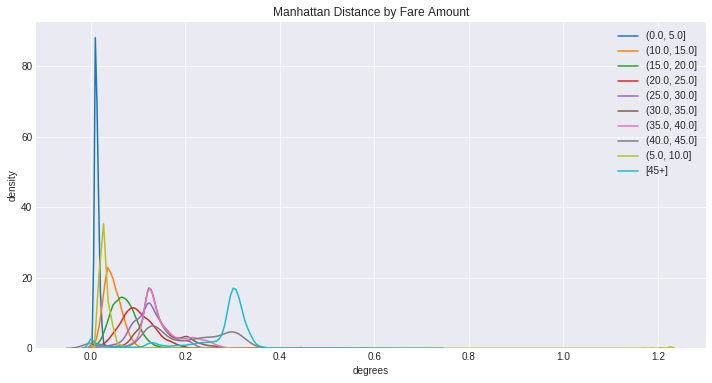

In [29]:
data['manhattan'] = minkowski_distance(data['pickup_longitude'], data['dropoff_longitude'],
                                       data['pickup_latitude'], data['dropoff_latitude'], 1)

plt.figure(figsize = (12, 6))

for f, grouped in data.groupby('fare-bin'):
    sns.kdeplot(grouped['manhattan'], label = f'{f}')

plt.xlabel('degrees')
plt.ylabel('density')
plt.title('Manhattan Distance by Fare Amount');

In [30]:
data.groupby('fare-bin')['manhattan'].agg(['mean', 'count'])

mean   count
fare-bin                      
(0.0, 5.0]    0.011980  126757
(10.0, 15.0]  0.046173  138378
(15.0, 20.0]  0.068757   45048
(20.0, 25.0]  0.097164   20623
(25.0, 30.0]  0.124364   15543
(30.0, 35.0]  0.138912   12317
(35.0, 40.0]  0.148707    6946
(40.0, 45.0]  0.193562    5202
(5.0, 10.0]   0.024891  358315
[45+]         0.264630   14997

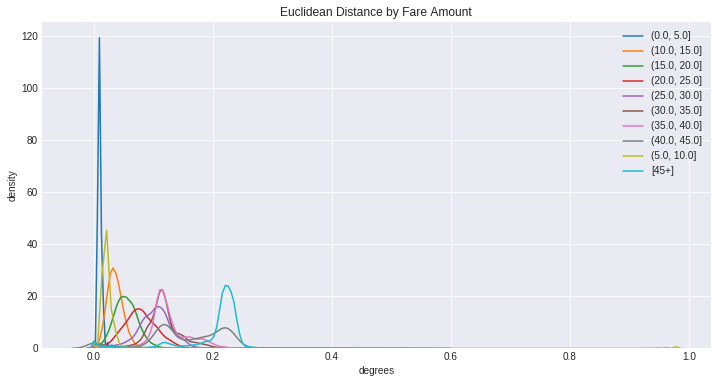

In [31]:
data['euclidean'] = minkowski_distance(data['pickup_longitude'], data['dropoff_longitude'],
                                       data['pickup_latitude'], data['dropoff_latitude'], 2)

plt.figure(figsize = (12, 6))
for f, grouped in data.groupby('fare-bin'):
    sns.kdeplot(grouped['euclidean'], label = f'{f}')

plt.xlabel('degrees')
plt.ylabel('density')
plt.title('Euclidean Distance by Fare Amount');

In [32]:
data.groupby('fare-bin')['euclidean'].agg(['mean', 'count'])

mean   count
fare-bin                      
(0.0, 5.0]    0.009144  126757
(10.0, 15.0]  0.035734  138378
(15.0, 20.0]  0.053711   45048
(20.0, 25.0]  0.077017   20623
(25.0, 30.0]  0.101558   15543
(30.0, 35.0]  0.115560   12317
(35.0, 40.0]  0.124742    6946
(40.0, 45.0]  0.153586    5202
(5.0, 10.0]   0.019128  358315
[45+]         0.197846   14997

### Haversine Distance

[A fórmula de Haversine](https://www.wikiwand.com/pt/F%C3%B3rmula_de_Haversine) é uma importante equação usada em navegação, fornecendo distâncias entre dois pontos de uma esfera a partir de suas latitudes e longitudes. É um caso especial de uma fórmula mais geral de trigonometria esférica, a lei dos Haversines, relacionando os lados a ângulos de uma esfera "triangular".

$${\displaystyle 2R\arcsin \left({\sqrt {\sin ^{2}\left({\frac {lat _{2}-lat _{1}}{2}}\right)+\cos(lat _{1})\cos(lat _{2})\sin ^{2}\left({\frac {lon _{2}-lon _{1}}{2}}\right)}}\right)}$$

[Funções matemáticas do numpy](https://docs.scipy.org/doc/numpy-1.15.1/reference/routines.math.html)

[Funcção implementada](https://stackoverflow.com/a/29546836)


In [33]:
# Radius of the earth in kilometers
R = 6378

def haversine_distance(lon1, lat1, lon2, lat2):
    # Converte latitude e longitude para radiano
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])

    # Calcula diferença entre latitude e longitude
    diffLat = lat2 - lat1
    diffLon = lon2 - lon1
    
    # Aplicando a formula 
    distance = 2 * R * np.arcsin( np.sqrt( np.square(np.sin(diffLat/2)) + np.cos(lat1) * np.cos(lat2) * np.square(np.sin(diffLon/2)) ) )
    
    return distance

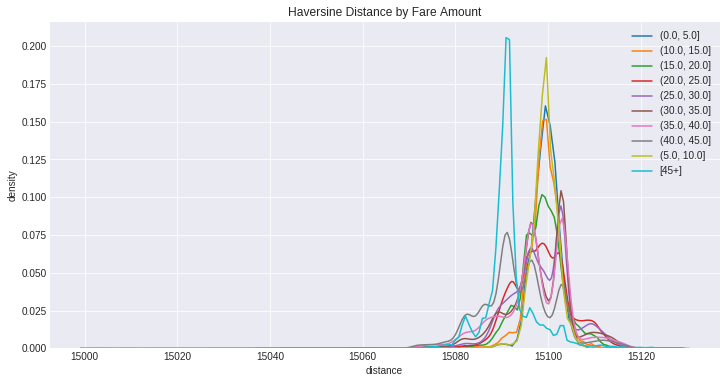

In [34]:
data['haversine'] = haversine_distance(data['pickup_longitude'], data['dropoff_longitude'],
                                       data['pickup_latitude'], data['dropoff_latitude'])

plt.figure(figsize = (12, 6))
for f, grouped in data.groupby('fare-bin'):
    sns.kdeplot(grouped['haversine'], label = f'{f}')

plt.xlabel('distance')
plt.ylabel('density')
plt.title('Haversine Distance by Fare Amount');

In [35]:
data.groupby('fare-bin')['haversine'].agg(['mean', 'count'])

mean   count
fare-bin                          
(0.0, 5.0]    15099.371206  126757
(10.0, 15.0]  15099.129945  138378
(15.0, 20.0]  15098.638718   45048
(20.0, 25.0]  15098.534543   20623
(25.0, 30.0]  15098.592354   15543
(30.0, 35.0]  15098.117135   12317
(35.0, 40.0]  15097.137720    6946
(40.0, 45.0]  15093.693312    5202
(5.0, 10.0]   15099.310833  358315
[45+]         15091.641934   14997

## Tempo de pegada do passageiro

https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.dt.html

In [36]:
data['pickup_datetime'].head()

0   2009-06-15 17:26:21+00:00
2   2011-08-18 00:35:00+00:00
3   2012-04-21 04:30:42+00:00
4   2010-03-09 07:51:00+00:00
6   2012-11-20 20:35:00+00:00
Name: pickup_datetime, dtype: datetime64[ns, UTC]

In [37]:
def info_from_pickup_datetime(data):
    data['year_pickup'] = data['pickup_datetime'].dt.year
    data['month_pickup'] = data['pickup_datetime'].dt.month
    data['day_pickup'] = data['pickup_datetime'].dt.day
    data['hour_pickup'] = data['pickup_datetime'].dt.hour

In [38]:
info_from_pickup_datetime(data)

In [39]:
data.head()

fare_amount           pickup_datetime  pickup_longitude  pickup_latitude  \
0          4.5 2009-06-15 17:26:21+00:00        -73.844311        40.721319   
2          5.7 2011-08-18 00:35:00+00:00        -73.982738        40.761270   
3          7.7 2012-04-21 04:30:42+00:00        -73.987130        40.733143   
4          5.3 2010-03-09 07:51:00+00:00        -73.968095        40.768008   
6          7.5 2012-11-20 20:35:00+00:00        -73.980002        40.751662   

   dropoff_longitude  dropoff_latitude  passenger_count     fare-bin  \
0         -73.841610         40.712278                1   (0.0, 5.0]   
2         -73.991242         40.750562                2  (5.0, 10.0]   
3         -73.991567         40.758092                1  (5.0, 10.0]   
4         -73.956655         40.783762                1  (5.0, 10.0]   
6         -73.973802         40.764842                1  (5.0, 10.0]   

                                               color  abs_lat_diff  \
0  (0.6509803921568628, 0.807843137254902, 0.8901...      0.009041   
2  (0.12156862745098039, 0.47058823529411764, 0.7...      0.010708   
3  (0.12156862745098039, 0.47058823529411764, 0.7...      0.024949   
4  (0.12156862745098039, 0.47058823529411764, 0.7...      0.015754   
6  (0.12156862745098039, 0.47058823529411764, 0.7...      0.013180   

   abs_lon_diff  manhattan  euclidean     haversine  year_pickup  \
0      0.002701   0.011742   0.009436  15092.034032         2009   
2      0.008504   0.019212   0.013674  15098.497877         2011   
3      0.004437   0.029386   0.025340  15098.557034         2012   
4      0.011440   0.027194   0.019470  15102.393629         2010   
6      0.006200   0.019380   0.014565  15099.954549         2012   

   month_pickup  day_pickup  hour_pickup  
0             6          15           17  
2             8          18            0  
3             4          21            4  
4             3           9            7  
6            11          20           20

In [40]:
data.corr()

fare_amount  pickup_longitude  pickup_latitude  \
fare_amount           1.000000          0.498357        -0.266951   
pickup_longitude      0.498357          1.000000        -0.208581   
pickup_latitude      -0.266951         -0.208581         1.000000   
dropoff_longitude     0.454771          0.293347        -0.031071   
dropoff_latitude     -0.187858         -0.031695         0.425722   
passenger_count       0.018941          0.006712        -0.006791   
abs_lat_diff          0.705510          0.315258        -0.257032   
abs_lon_diff          0.834977          0.550671        -0.267733   
manhattan             0.886423          0.516197        -0.298277   
euclidean             0.901521          0.519578        -0.292749   
haversine            -0.274304         -0.301245         0.621563   
year_pickup           0.119600          0.017402        -0.011243   
month_pickup          0.027268          0.008568        -0.003748   
day_pickup            0.002180         -0.000596        -0.001366   
hour_pickup          -0.017510          0.014756         0.033708   

                   dropoff_longitude  dropoff_latitude  passenger_count  \
fare_amount                 0.454771         -0.187858         0.018941   
pickup_longitude            0.293347         -0.031695         0.006712   
pickup_latitude            -0.031071          0.425722        -0.006791   
dropoff_longitude           1.000000         -0.022815         0.003915   
dropoff_latitude           -0.022815          1.000000        -0.004703   
passenger_count             0.003915         -0.004703         1.000000   
abs_lat_diff                0.306831         -0.126407         0.011520   
abs_lon_diff                0.516537         -0.146028         0.012411   
manhattan                   0.489267         -0.156403         0.013647   
euclidean                   0.495183         -0.165539         0.013835   
haversine                   0.064117          0.927585        -0.006575   
year_pickup                 0.011173         -0.004074         0.005699   
month_pickup                0.007038         -0.004130         0.004561   
day_pickup                  0.002444         -0.001626         0.003893   
hour_pickup                -0.061732          0.017938         0.020440   

                   abs_lat_diff  abs_lon_diff  manhattan  euclidean  \
fare_amount            0.705510      0.834977   0.886423   0.901521   
pickup_longitude       0.315258      0.550671   0.516197   0.519578   
pickup_latitude       -0.257032     -0.267733  -0.298277  -0.292749   
dropoff_longitude      0.306831      0.516537   0.489267   0.495183   
dropoff_latitude      -0.126407     -0.146028  -0.156403  -0.165539   
passenger_count        0.011520      0.012411   0.013647   0.013835   
abs_lat_diff           1.000000      0.542576   0.822918   0.795785   
abs_lon_diff           0.542576      1.000000   0.923754   0.931466   
manhattan              0.822918      0.923754   1.000000   0.992845   
euclidean              0.795785      0.931466   0.992845   1.000000   
haversine             -0.195472     -0.243472  -0.253800  -0.260139   
year_pickup            0.018067      0.028750   0.027683   0.027412   
month_pickup           0.010405      0.014254   0.014385   0.014365   
day_pickup             0.002863      0.002919   0.003279   0.003377   
hour_pickup           -0.018716     -0.028717  -0.027957  -0.029595   

                   haversine  year_pickup  month_pickup  day_pickup  \
fare_amount        -0.274304     0.119600      0.027268    0.002180   
pickup_longitude   -0.301245     0.017402      0.008568   -0.000596   
pickup_latitude     0.621563    -0.011243     -0.003748   -0.001366   
dropoff_longitude   0.064117     0.011173      0.007038    0.002444   
dropoff_latitude    0.927585    -0.004074     -0.004130   -0.001626   
passenger_count    -0.006575     0.005699      0.004561    0.003893   
abs_lat_diff       -0.195472     0.018067      0.010405    0.002863   
abs_lon_

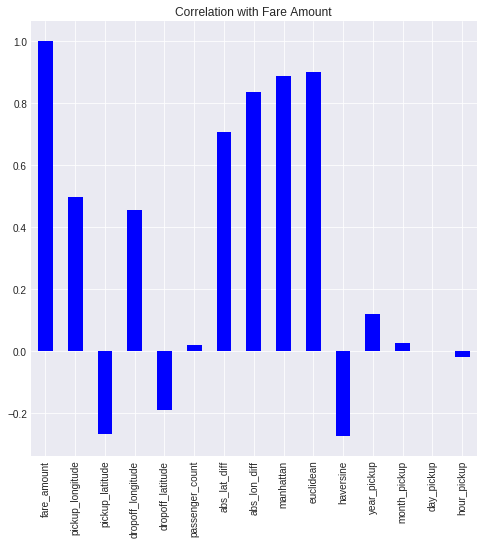

In [41]:
corrs = data.corr()
plt.figure(figsize=(8,8))
corrs['fare_amount'].plot.bar(color = 'b');
plt.title('Correlation with Fare Amount');

## Removendo features desnecessarias

In [42]:
fare = data['fare-bin']
data.drop(labels=['pickup_datetime', 'fare-bin'], axis=1, inplace=True)

In [43]:
data.head()

fare_amount  pickup_longitude  pickup_latitude  dropoff_longitude  \
0          4.5        -73.844311        40.721319         -73.841610   
2          5.7        -73.982738        40.761270         -73.991242   
3          7.7        -73.987130        40.733143         -73.991567   
4          5.3        -73.968095        40.768008         -73.956655   
6          7.5        -73.980002        40.751662         -73.973802   

   dropoff_latitude  passenger_count  \
0         40.712278                1   
2         40.750562                2   
3         40.758092                1   
4         40.783762                1   
6         40.764842                1   

                                               color  abs_lat_diff  \
0  (0.6509803921568628, 0.807843137254902, 0.8901...      0.009041   
2  (0.12156862745098039, 0.47058823529411764, 0.7...      0.010708   
3  (0.12156862745098039, 0.47058823529411764, 0.7...      0.024949   
4  (0.12156862745098039, 0.47058823529411764, 0.7...      0.015754   
6  (0.12156862745098039, 0.47058823529411764, 0.7...      0.013180   

   abs_lon_diff  manhattan  euclidean     haversine  year_pickup  \
0      0.002701   0.011742   0.009436  15092.034032         2009   
2      0.008504   0.019212   0.013674  15098.497877         2011   
3      0.004437   0.029386   0.025340  15098.557034         2012   
4      0.011440   0.027194   0.019470  15102.393629         2010   
6      0.006200   0.019380   0.014565  15099.954549         2012   

   month_pickup  day_pickup  hour_pickup  
0             6          15           17  
2             8          18            0  
3             4          21            4  
4             3           9            7  
6            11          20           20

# Machine Learning

In [44]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings('ignore', category = RuntimeWarning)


In [45]:
lr = LinearRegression()

In [46]:
X_train, X_valid, y_train, y_valid = train_test_split(data, np.array(data['fare_amount']), 
                                                      stratify = fare,
                                                      random_state = RSEED, test_size = 0.2)

In [47]:
lr.fit(X_train[['abs_lat_diff', 'abs_lon_diff', 'passenger_count']], y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [48]:
def metrics(train_pred, valid_pred, y_train, y_valid):
    # Calculando mean squared error
    train_rmse = np.sqrt(mean_squared_error(y_train, train_pred))
    valid_rmse = np.sqrt(mean_squared_error(y_valid, valid_pred))
    
    # Calculando absolute percentage error
    train_ape = abs((y_train - train_pred) / y_train)
    valid_ape = abs((y_valid - valid_pred) / y_valid)
    
    # Colocando os infinitos para zerp
    train_ape[train_ape == np.inf] = 0
    train_ape[train_ape == -np.inf] = 0
    valid_ape[valid_ape == np.inf] = 0
    valid_ape[valid_ape == -np.inf] = 0
    
    # Fazendo o percentual     
    train_mape = 100 * np.mean(train_ape)
    valid_mape = 100 * np.mean(valid_ape)
    
    return train_rmse, valid_rmse, train_mape, valid_mape

def evaluate(model, features, X_train, X_valid, y_train, y_valid):
    # Fazendo a predição com o modelo
    train_pred = model.predict(X_train[features])
    valid_pred = model.predict(X_valid[features])
    
    # Obtendo os resuktados das metricas
    train_rmse, valid_rmse, train_mape, valid_mape = metrics(train_pred, valid_pred,
                                                             y_train, y_valid)
         
    print(f'Training:   rmse = ${round(train_rmse, 2)} \t mape = {round(train_mape, 2)}%')
    print(f'Validation: rmse = ${round(valid_rmse, 2)} \t mape = {round(valid_mape, 2)}%')

In [49]:
evaluate(lr, ['abs_lat_diff', 'abs_lon_diff', 'passenger_count'], 
        X_train, X_valid, y_train, y_valid)

Training:   rmse = $4.27 	 mape = 24.85%
Validation: rmse = $4.27 	 mape = 24.91%


In [50]:
train_mean = y_train.mean()

# Criando uma lista com a mesma predição para todos os dados de treino e teste
train_preds = [train_mean for _ in range(len(y_train))]
valid_preds = [train_mean for _ in range(len(y_valid))]

tr, vr, tm, vm = metrics(train_preds, valid_preds, y_train, y_valid)

print(f'Baseline Training:   rmse = {round(tr, 2)} \t mape = {round(tm, 2)}')
print(f'Baseline Validation: rmse = {round(vr, 2)} \t mape = {round(vm, 2)}')

Baseline Training:   rmse = 9.27 	 mape = 65.25
Baseline Validation: rmse = 9.26 	 mape = 65.27


#### Agora é sua vez